In [1]:
import numpy as np
import pandas as pd
import pickle
import itertools
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import catboost as catb

In [2]:
RANDOM_STATE = 200

In [3]:
ANSWER_TEST_PATH = 'answers_test.csv'
users_data_df_PATH = 'data_test.csv'
DATA_TRAIN_FEATURES_PATH = 'data_train_features.csv'
DATA_TEST_FEATURES_PATH = 'data_test_features.csv'

In [4]:
data_train  = pd.read_csv(DATA_TRAIN_FEATURES_PATH)

data_train.head()

,id,vas_id,target,0,1,2,3,4,5,6,...,246,247,248,249,250,251,252,week_on_month,day,month
0,2582523,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7
1,1292549,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7
2,4053116,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7
3,4158361,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7
4,3754468,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7


In [5]:
# Разделим признаки и целевую переменную
data_prelim = data_train.copy()

X = data_prelim.drop('target', axis=1)
y = data_prelim['target']

In [6]:
X.loc[(X['252'] > 1, '252')] = 2.0

In [7]:
X.head()

,id,vas_id,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,week_on_month,day,month
0,2582523,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7
1,1292549,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7
2,4053116,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7
3,4158361,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7
4,3754468,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7


In [8]:
print("ID уникален? ", X.index.is_unique)
print("Есть ли дубли в строках?", X.duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((X.isnull().sum() > 0).sum()/X.shape[1]*100))

ID уникален?  True
Есть ли дубли в строках? 0
Сколько процент признаков могут принимать null-значениями? 98%


Опредлеяем типы переменных

In [9]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))

In [10]:
X_nunique

id               806613
vas_id                8
0                 32843
1                 84458
2                 40196
                  ...  
251                 210
252                   4
week_on_month         5
day                  22
month                 6
Length: 258, dtype: int64

In [11]:
f_all = set(X_nunique.index.tolist())
len(f_all)

258

In [12]:
#### Константные признаки
f_const = set(X_nunique[X_nunique == 1].index.tolist())

f_other = f_all - f_const
len(f_const), len(f_other)

(0, 258)

In [13]:
#### Бинарные
f_binary = set(X.loc[:, f_other].columns[(
                      (X.loc[:, f_other].max() == 1) & \
                      (X.loc[:, f_other].min() == 0) & \
                      (X.loc[:, f_other].isnull().sum() == 0))])

# f_other = f_all - (f_binary | f_const)
f_other = f_other - f_binary

len(f_binary), len(f_other)

(0, 258)

In [14]:
#### Категориальные
f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 5].index.tolist())
f_numeric_extra = f_categorical
f_other = f_other - f_categorical

len(f_categorical), len(f_other)

(30, 228)

In [15]:
#### Вещественные признаки
f_numeric = (X[f_other].fillna(0).astype(int).sum() - X[f_other].fillna(0).sum()).abs() 
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
f_other = f_other - f_numeric
# f_other = f_all - (f_numeric | f_const)
len(f_numeric), len(f_other)

(224, 4)

In [16]:
f_numeric = f_numeric | f_other
f_other = f_other - f_numeric
len(f_other)

0

In [17]:
print('f_all:', len(f_all))
print()
print('f_const:', len(f_const))
print('f_binary:', len(f_binary))
print('f_categorical:', len(f_categorical))
print('f_numeric:', len(f_numeric))

f_ok = list(f_binary | f_categorical | f_numeric)
f_binary, f_categorical, f_numeric = list(f_binary), list(f_categorical), list(f_numeric)

f_all: 258

f_const: 0
f_binary: 0
f_categorical: 30
f_numeric: 228


In [18]:
train_idx, test_idx = train_test_split(X.index, test_size=0.25, random_state=RANDOM_STATE)

y_train, y_test = y.loc[train_idx], y.loc[test_idx]
x_train, x_test = X.loc[train_idx], X.loc[test_idx]

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

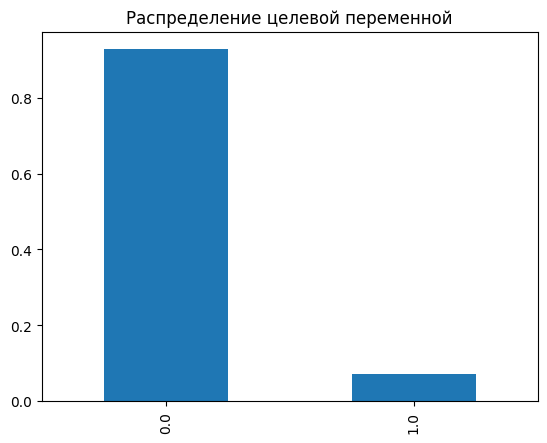

In [19]:
(y.value_counts()/y.shape[0]).plot(kind='bar', title='Распределение целевой переменной');
y.value_counts()/y.shape

In [20]:
ros = RandomUnderSampler(random_state=42)
x_train, y_train = ros.fit_resample(x_train, y_train)

print("Train")
print(y_train.value_counts()/y_train.shape[0])
print()
print("Test")
print(y_test.value_counts()/y_test.shape[0])

Train
0.0    0.5
1.0    0.5
Name: target, dtype: float64

Test
0.0    0.927941
1.0    0.072059
Name: target, dtype: float64


Обучение модели

In [21]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

In [22]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numeric),
            SimpleImputer(strategy="median"), # Заполнение пропусков.
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(f_binary),
        ))
    ])
)

In [23]:
catb_model = catb.CatBoostClassifier(#silent=True,
                                    random_state=21,
                                    # class_weights=[1, disbalance],
                                    score_function='L2',
                                    depth = 7,
                                    eval_metric='AUC',
                                    use_best_model=True,
                                    boosting_type = 'Ordered', #  / Plain 
                                    l2_leaf_reg = 3, # -- регуляризация. 3.0 = по умолчанию. 
                                    # eta = 0.5,
                                    learning_rate=0.1,
                                    custom_metric=['Precision', 'Recall'],
                                    iterations=10000,
                                    early_stopping_rounds=200,
                                    verbose=100,                                    
                                )

In [24]:
cat_boost_pipe = make_pipeline(
    f_prep_pipeline,
    # TruncatedSVD(n_components=150, n_iter=7, random_state=42),# PCA(n_components=20, whiten=True),
    catb_model
)

In [25]:
X_train_transformed = cat_boost_pipe[:-1].fit_transform(x_train)
x_test_transformed = cat_boost_pipe[:-1].transform(x_test)

In [26]:
%%time
cat_boost_pipe[-1].fit(
       X=X_train_transformed,
       y=y_train,
       eval_set=[(x_test_transformed, y_test)],
     )

0:	test: 0.9205595	best: 0.9205595 (0)	total: 354ms	remaining: 59m 2s
100:	test: 0.9308513	best: 0.9311225 (62)	total: 29.2s	remaining: 47m 41s
200:	test: 0.9302487	best: 0.9311225 (62)	total: 58.8s	remaining: 47m 47s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9311225274
bestIteration = 62

Shrink model to first 63 iterations.
CPU times: user 9min 50s, sys: 3.83 s, total: 9min 54s
Wall time: 1min 19s


Построение предсказаний на тестовой выборке, оценка к-ва модели

In [27]:
test_score = cat_boost_pipe.predict(x_test)

In [28]:
def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[167180  25752]
 [  1343  13639]]


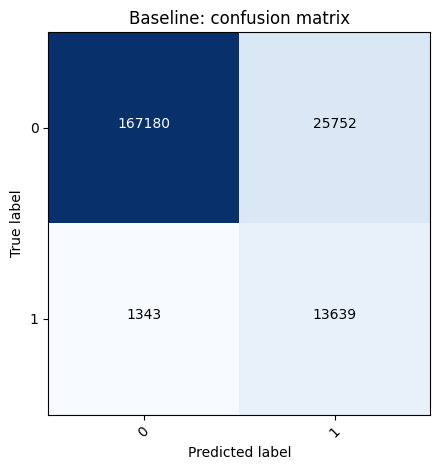

In [29]:
cm = confusion_matrix(y_test, test_score > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="Baseline");

In [30]:
print(classification_report(y_test, test_score > 0.5))

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    192932
         1.0       0.35      0.91      0.50     14982

    accuracy                           0.87    207914
   macro avg       0.67      0.89      0.71    207914
weighted avg       0.95      0.87      0.89    207914



In [31]:
fpr, tpr, roc_thresholds = roc_curve(y_test, test_score)
precision, recall, pr_thresholds = precision_recall_curve(y_test, test_score)

Baseline: AUC_ROC = 0.888


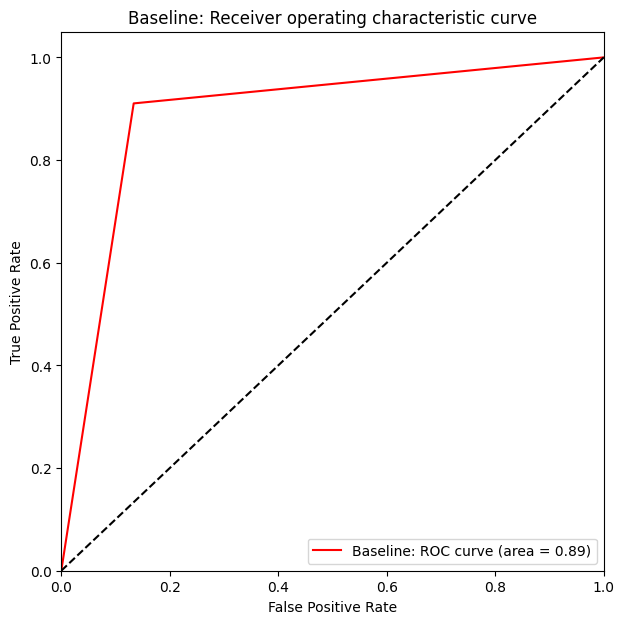

In [32]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Baseline", color='r')
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))

Baseline: AUC_PR = 0.632


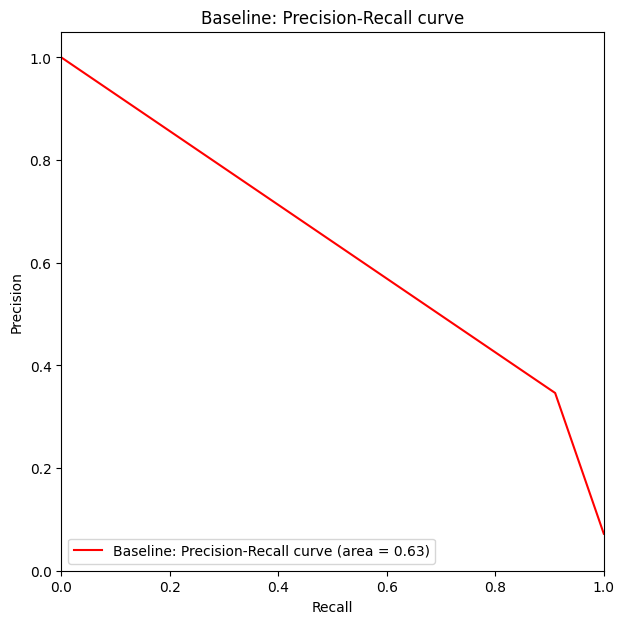

In [33]:
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

plt.figure(figsize=(7, 7))
    
plot_precision_recall_curve(recall, precision, "Baseline", color='r')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))

In [34]:
feature_importance = catb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
features_count  = len(f_all)

In [35]:
sorted_idx_ex = []
for ind in  sorted_idx:
    if ind < features_count:
        sorted_idx_ex.append(ind)

In [36]:
importance_features = np.array(x_test.columns)[sorted_idx_ex] # в конечном счете обучать модель будем только на этих фитчах.

Text(0.5, 1.0, 'Feature Importance')

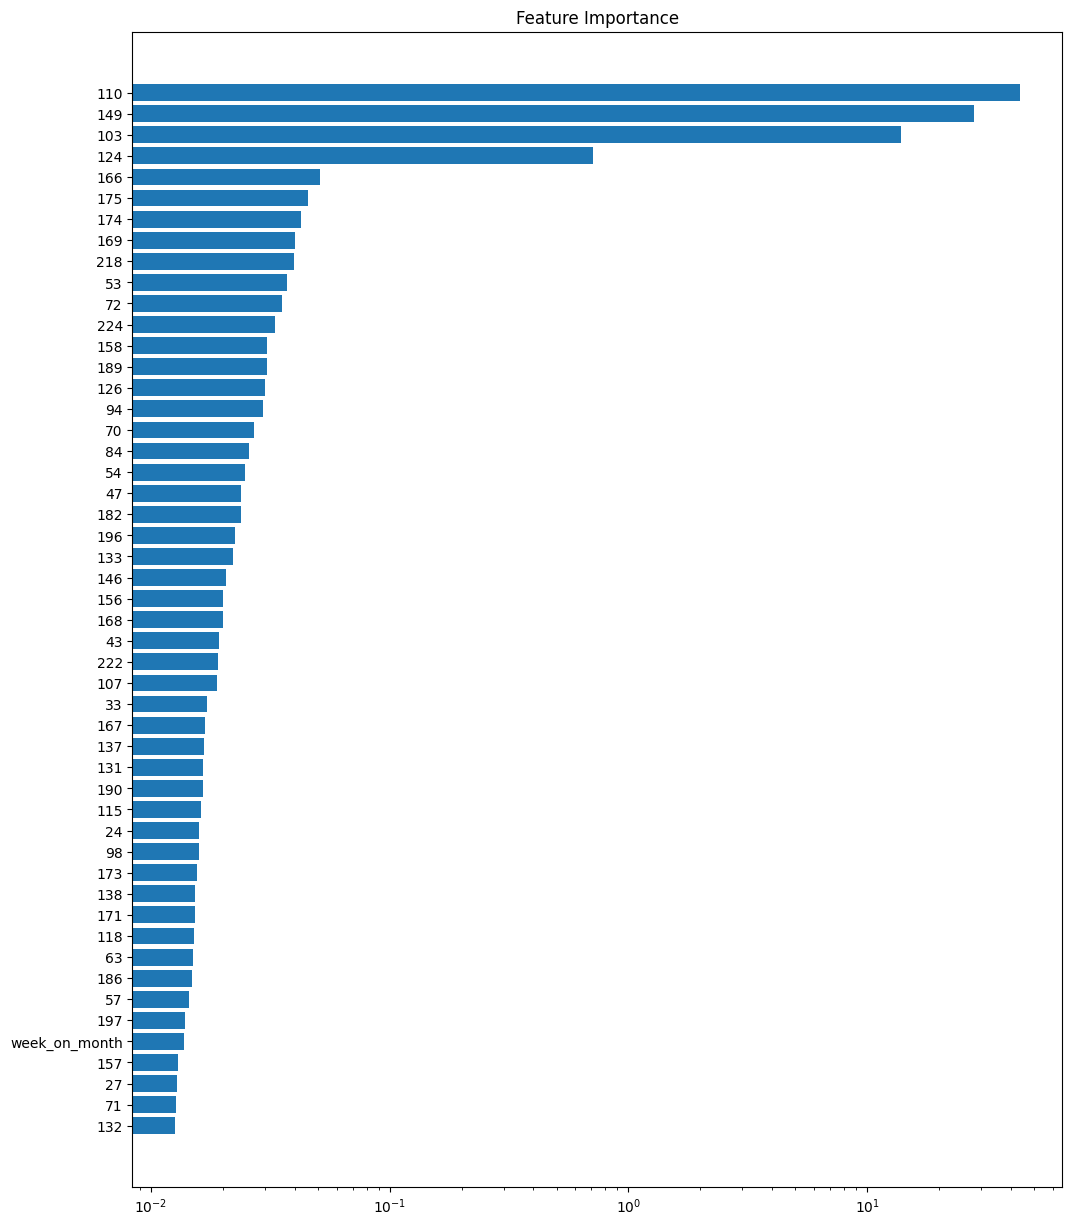

In [37]:
top_count = 50
fig = plt.figure(figsize=(12, 15))
plt.barh(range(top_count), feature_importance[sorted_idx_ex][-top_count:], align='center')
plt.yticks(range(top_count), np.array(x_test.columns)[sorted_idx_ex][-top_count:])
plt.xscale('log')
plt.title('Feature Importance')

In [38]:
with open('catboost_model.pickle', 'wb') as f:
    pickle.dump(cat_boost_pipe, f, protocol=pickle.HIGHEST_PROTOCOL)

Финальное предсказание

In [39]:
with open('catboost_model.pickle', 'rb') as f:
    cat_boost_pipe =  pickle.load(f)

In [40]:
data_test  = pd.read_csv(DATA_TEST_FEATURES_PATH)

In [41]:
data_test.loc[(data_test['252'] > 1, '252')] = 2.0

In [42]:
y_result_pred = cat_boost_pipe.predict(data_test) 

In [43]:
y_result_pred

array([0., 0., 1., ..., 0., 1., 0.])

In [44]:
x_test = pd.read_csv(users_data_df_PATH)
x_test = x_test.drop('Unnamed: 0', axis=1)

In [45]:
x_test['target'] = y_result_pred

In [46]:
x_test.to_csv(ANSWER_TEST_PATH, index=False)

In [47]:
x_test.head()

,id,vas_id,buy_time,target
0,3130519,2.0,1548018000,0.0
1,2000860,4.0,1548018000,0.0
2,1099444,2.0,1546808400,1.0
3,1343255,5.0,1547413200,1.0
4,1277040,2.0,1546808400,1.0
